In [2]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Highlight what's the diff between co-center and re-center:
    
    

**co-center**:
    
* only done once, in [0th iteration](https://github.com/lsst-ts/ts_wep/blob/6a99e8e438dec9a1f67c659dd1eddee395276d72/python/lsst/ts/wep/cwfs/Algorithm.py#L706) 
* corrects using the ZEMAX-calculated distortion coefficient, that depends on the distance from the center of the field of view  <img src="fig_cocenter.png" alt="Field distance-radial shift (image co-center) " width='500 px' >
* calculated so that reference distortion at the edge of the focal plane is 3.5, and then it's scaled by the distance from the center of the FOV. It seems at this point accidental that the reference amount of distortion is numerically identical  to the field of view diameter
* doesn't depend on the optical model 


**re-center**:
* part of `compensate` stage which is done at [every iteration](https://github.com/lsst-ts/ts_wep/blob/6a99e8e438dec9a1f67c659dd1eddee395276d72/python/lsst/ts/wep/cwfs/Algorithm.py#L748)  
* done to align the image with the interpolation template used to transform the image from donut plane to pupil plane 

In [3]:
def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog

def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0,
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId,
                          collections=[collection])
    return postIsr

In [7]:
#repo_dir  = 'DM-35919_phosim_example/example_wfs/phosimData'
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name) 
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)
sensor='R04'
extraImage = get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# inside wfEsti = WfEstimator(instDir, algoDir)

# this is part of the init
inst = Instrument(instDir)
algo = Algorithm(algoDir)

# inside estimateZernikes()
instName='lsst'
camType = getCamType(instName)
defocalDisInMm = getDefocalDisInMm(instName)

# inside wfEsti.config
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select the only donut pair in that corner
i=1
donutExtra = donutStampsExtra[i]
j=4
donutIntra = donutStampsIntra[j]

# Inside EstimateZernikesBase
# Transpose field XY because CompensableImages below are transposed
# so this gets the correct mask orientation in Algorithm.py
fieldXYExtra = donutExtra.calcFieldXY()[::-1]
fieldXYIntra = donutIntra.calcFieldXY()[::-1]

camera = donutExtra.getCamera() # same camera for both donuts
detectorExtra = camera.get(donutExtra.detector_name)
detectorIntra = camera.get(donutIntra.detector_name)


# Rotate any sensors that are not lined up with the focal plane.
# Mostly just for the corner wavefront sensors. The negative sign
# creates the correct rotation based upon closed loop tests
# with R04 and R40 corner sensors.
eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated later in Algorithm
maskScalingFactorLocal = 1


# rename to just like it is in Algorithm.py
I1 = imgIntra
I2 = imgExtra
model = opticalModel
tol = 1e-3 


itr = algo.currentItr
# Use the zonal mode ("zer")
compMode = algo.getCompensatorMode()

# Define the gain of feedbackGain
feedbackGain = algo.getFeedbackGain()

# Set the pre-condition
if algo.currentItr == 0:

    # Check this is the first time of running iteration or not
    if I1.getImgInit() is None or I2.getImgInit() is None:

        # Check the image dimension
        if I1.getImg().shape != I2.getImg().shape:
            print(
                "Error: The intra and extra image stamps need to be of same size."
            )
          

        # Calculate the pupil mask (binary matrix) and related
        # parameters
        boundaryT = algo.getBoundaryThickness()
        I1.makeMask(algo._inst, model, boundaryT, 1)
        I2.makeMask(algo._inst, model, boundaryT, 1)
    
algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())

# Load the offAxis correction coefficients
if model == "offAxis":
    offAxisPolyOrder = algo.getOffAxisPolyOrder()
    I1.setOffAxisCorr(algo._inst, offAxisPolyOrder)
    I2.setOffAxisCorr(algo._inst, offAxisPolyOrder)

# store images before co-centering
I1imgInit = I1.getImg()
I2imgInit = I2.getImg()



## Image Cocenter (0th iteration only) in detail

What the `coCenter` step does is to:
* find the center of mass  of the image binary using `scipy.ndimage.center_of_mass`  (`x1`, `y1`)
* find the center of the image `xc`, `yc`   ( called in coCenter `stampCenterx1`, `stampCentery1`)
* find the radial shift given the `pixelSize`, defocal `offset` , reference distortion value in pixels (called `fov`), scale it by the distance to the center of FOV  `fieldDist/(fov/2)`, decompose radial shift into x,y components : `xShift`, `yShift`
* apply `xShift`, `yShift` to the stamp center coordinates, getting shifted x,y coordinates (`xcs = xc + xShift` )
* roll the image  by the difference between the original `x1`,`y1` and the `xcs`, `ycs` coordinates

In [4]:
def imageCoCenterDiagnostic(I, inst, fov=3.5, debugLevel=0):
        """Shift the weighting center of donut to the center of reference
        image with the correction of projection of fieldX and fieldY.
        
        Parameters
        ----------
        inst : Instrument
            Instrument to use.
        fov : float, optional
            Field of view (FOV) of telescope. (the default is 3.5.)
        debugLevel : int, optional
            Show the information under the running. If the value is higher, the
            information shows more. It can be 0, 1, 2, or 3. (the default is
            0.)
        """

        # Calculate the weighting center (x, y) and radius
        x1, y1 = I._image.getCenterAndR()[0:2]

        # Show the co-center information
        if debugLevel >= 3:
            print("imageCoCenter: (x, y) = (%8.2f,%8.2f)\n" % (x1, y1))

        # Calculate the center position on image
        # 0.5 is the half of 1 pixel
        dimOfDonut = inst.getDimOfDonutOnSensor()
        stampCenterx1 = dimOfDonut / 2 + 0.5
        stampCentery1 = dimOfDonut / 2 + 0.5

        print('dimension of donut stamp:', dimOfDonut)
        print('x,y center:', stampCenterx1, stampCentery1)


        # Shift in the radial direction
        # The field of view (FOV) of LSST camera is 3.5 degree
        offset = inst.getDefocalDisOffset()
        pixelSize = inst.getCamPixelSize()
        radialShift = fov * (offset / 1e-3) * (10e-6 / pixelSize)
        print(f'defocal  offset in meters: {offset}, pixel size in meters: {pixelSize}')


        # Calculate the projection of distance of donut to center
        fieldDist = I._getFieldDistFromOrigin()
        radialShift = radialShift * (fieldDist / (fov / 2))

        print(f'field distance in degrees: {fieldDist}')
        print(f'radialShift in pixels :{radialShift}')

        # Do not consider the condition out of FOV of lsst
        if fieldDist > (fov / 2):
            radialShift = 0

        # Calculate the cos(theta) for projection
        I1c = I.fieldX / fieldDist

        # Calculate the sin(theta) for projection
        I1s = I.fieldY / fieldDist

        # Get the projected x, y-coordinate
        stampCenterx1 = stampCenterx1 + radialShift * I1c
        stampCentery1 = stampCentery1 + radialShift * I1s
        
        yshift = int(np.round(stampCentery1 - y1)) 
        xshift = int(np.round(stampCenterx1 - x1))
        
        print(f'xshift:{xshift} [px], yshift:{yshift} [px]')
        
        return xshift, yshift

In [13]:
inst = algo._inst
fov = 3.5
debugLevel = 3

I = I1 

x1, y1 = I._image.getCenterAndR()[0:2]

# Show the co-center information
if debugLevel >= 3:
    print("imageCoCenter: (x, y) = (%8.2f,%8.2f)\n" % (x1, y1))

# Calculate the center position on image
# 0.5 is the half of 1 pixel
dimOfDonut = inst.getDimOfDonutOnSensor()
stampCenterx1 = dimOfDonut / 2 + 0.5
stampCentery1 = dimOfDonut / 2 + 0.5

print('dimension of donut stamp:', dimOfDonut)
print('x,y center:', stampCenterx1, stampCentery1)


# Shift in the radial direction
# The field of view (FOV) of LSST camera is 3.5 degree
offset = inst.getDefocalDisOffset()
pixelSize = inst.getCamPixelSize()
radialShift = fov * (offset / 1e-3) * (10e-6 / pixelSize)
print(f'defocal  offset in meters: {offset}, pixel size in meters: {pixelSize}')
print(f'radialShift at fov/2, i.e edge of fov is {radialShift} [px]')

# Calculate the projection of distance of donut to center
fieldDist = I._getFieldDistFromOrigin()



radialShift = radialShift * (fieldDist / (fov / 2))

imageCoCenter: (x, y) = (   80.17,   76.94)

dimension of donut stamp: 160
x,y center: 80.5 80.5
defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
radialShift at fov/2, i.e edge of fov is 5.25 [px]


In [17]:
offset

0.0015

In [18]:
pixelSize

1e-05

In [15]:
I._getFieldDistFromOrigin?

Text(0.5, 1.0, 'offset 0.0015, pixelSize 1e-5')

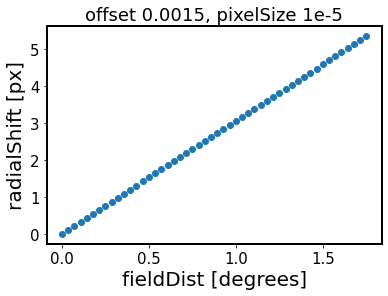

In [19]:
fieldDist = np.linspace(0,fov/2)
plt.scatter(fieldDist, radialShift * (fieldDist / (fov / 2)))
plt.xlabel('fieldDist [degrees]')
plt.ylabel('radialShift [px]')
plt.title('offset 0.0015, pixelSize 1e-5')

In [7]:
I1shifts = imageCoCenterDiagnostic(I1, algo._inst, fov=3.5, debugLevel=3)
I2shifts = imageCoCenterDiagnostic(I2, algo._inst, fov=3.5, debugLevel=3)

# Cocenter the images to the center referenced to fieldX and
# fieldY. Need to check the availability of this.
I1.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)
I2.imageCoCenter(algo._inst, debugLevel=algo.debugLevel)

# Update the self-initial image
I1.updateImgInit()
I2.updateImgInit()

# Initialize the variables used in the iteration.
algo.zcomp = np.zeros(algo.getNumOfZernikes())
algo.zc = algo.zcomp.copy()

dimOfDonut = algo._inst.getDimOfDonutOnSensor()
algo.wcomp = np.zeros((dimOfDonut, dimOfDonut))
algo.West = algo.wcomp.copy()

algo.caustic = False


# Rename this index (currentItr) for the simplification
jj = algo.currentItr

# Solve the transport of intensity equation (TIE)
if not algo.caustic:

    # Reset the images before the compensation
    I1.updateImage(I1.getImgInit().copy())
    I2.updateImage(I2.getImgInit().copy())
    
    if compMode == "zer":

        # Zk coefficient from the previous iteration
        ztmp = algo.zc.copy()

        # Do the feedback of Zk from the lower terms first based on the
        # sequence defined in compSequence
        if jj != 0:
            compSequence = algo.getCompSequence()
            print(compSequence)
            ztmp[int(compSequence[jj - 1]) :] = 0

        print(f'ztmp:{ztmp}')
        print(f'zcomp:{algo.zcomp}')
        print(f'feedbackGain:{feedbackGain}')
        print(f'ztmp*feedbackGain:{ztmp*feedbackGain}')

        # Add partial feedback of residual estimated wavefront in Zk
        algo.zcomp = algo.zcomp + ztmp * feedbackGain
        print(f'zcomp:{algo.zcomp}')
        
# store the image so that nothing in the below will affect it 
intraBeforeCompensate = I1.getImg()

# the calculated coefficients of the wavefront
zcCol = algo.zcomp

imageCoCenter: (x, y) = (   80.17,   76.94)

dimension of donut stamp: 160
x,y center: 80.5 80.5
defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
field distance in degrees: 1.779943759731931
radialShift in pixels :5.339831279195793
xshift:0 [px], yshift:4 [px]
imageCoCenter: (x, y) = (   80.56,   80.03)

dimension of donut stamp: 160
x,y center: 80.5 80.5
defocal  offset in meters: 0.0015, pixel size in meters: 1e-05
field distance in degrees: 1.661291879099434
radialShift in pixels :4.9838756372983015
xshift:-4 [px], yshift:4 [px]
ztmp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
feedbackGain:0.6
ztmp*feedbackGain:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
zcomp:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Image re-center (each iteration, inside compensate) - in detail

Just for intra-focal : 

In [8]:
from scipy.ndimage import generate_binary_structure, iterate_structure
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.interpolate import RectBivariateSpline
from scipy.signal import correlate

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularGrad,
    ZernikeAnnularJacobian,
)

# Dimension of image
sm, sn = I1.getImg().shape

print('Image dimension:', sm, sn)

# Dimension of projected image on focal plane
projSamples = sm

# Let us create a look-up table for x -> xp first.
luty, lutx = np.mgrid[
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),
    -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),

]

sensorFactor = algo._inst.getSensorFactor()
lutx = lutx / (projSamples / 2 / sensorFactor)
luty = luty / (projSamples / 2 / sensorFactor)


# Set up the mapping
lutxp, lutyp, J = I1._aperture2image(
inst, algo, zcCol, lutx, luty, projSamples, model
)

show_lutxyp = I1._showProjection(
            lutxp, lutyp, sensorFactor, projSamples, raytrace=False
        )



Image dimension: 160 160


In [9]:
projSamples

160

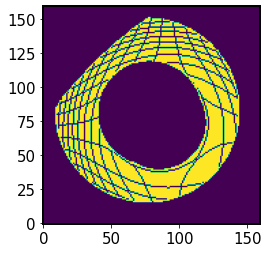

In [10]:
plt.imshow(show_lutxyp, origin='lower')

Next step adds a margin of 20 pixels in each dimension to make room for the morphological operations:

In [11]:
# Extend the dimension of image by 20 pixel in x and y direction
show_lutxyp_padded = padArray(show_lutxyp, projSamples + 20)


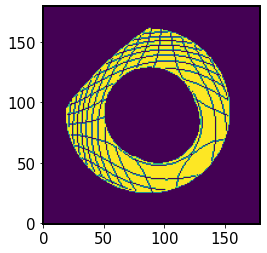

In [12]:
plt.imshow(show_lutxyp_padded, origin='lower')

This just made the stamp larger in each dimension

In [13]:
# Get the binary matrix of image on pupil plane if raytrace=False
struct0 = generate_binary_structure(2, 1)
struct0

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

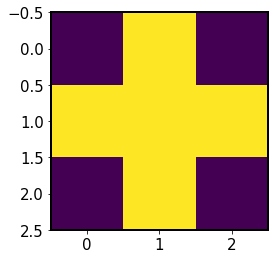

In [14]:
plt.imshow(struct0)

In [15]:
struct1 = iterate_structure(struct0, 4)
struct1

array([[False, False, False, False,  True, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False, False],
       [False,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False, False],
       [False, False, False, False,  True, False, False, False, False]])

Dilation and erosion are two of the fundamental operations in morphological image processing  (see eg. [Sapiro+1993](https://www.cs.technion.ac.il/~ron/PAPERS/morphology_1993.pdf)). 

This step dilates the structure with itself, from a 3x3 array it makes an 9x9 array:

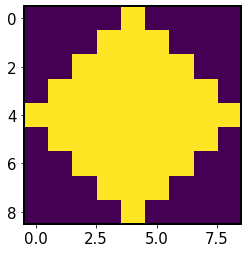

In [16]:
plt.imshow(struct1)

Next we dilate this structure with the one we started with twice: 

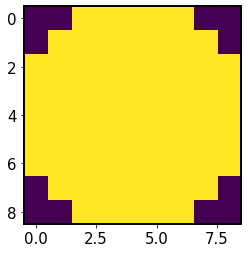

In [17]:
struct = binary_dilation(struct1, structure=struct0, iterations=2).astype(int)
plt.imshow(struct)

Now using this as a structuring element we perform binary dilation on the projection lookup table. It effectively erases the marks of the projection grid and enlarges slightly the envelope of the LUT:

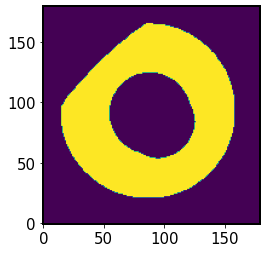

In [18]:
show_lutxyp_dilated = binary_dilation(show_lutxyp_padded, structure=struct)
plt.imshow(show_lutxyp_dilated, origin='lower')

Now this is eroded, to remove the unneccessarily-added envelope:

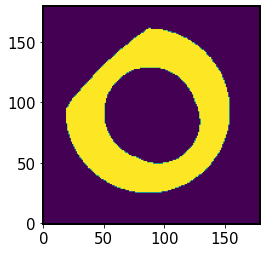

In [19]:
show_lutxyp_eroded = binary_erosion(show_lutxyp_dilated, structure=struct)
plt.imshow(show_lutxyp_eroded, origin='lower')

Next we extract the region in size equal to the original image  (160x160 px), since earlier we padded it by 20 pixels in each direction to allow the binary dilation to work:

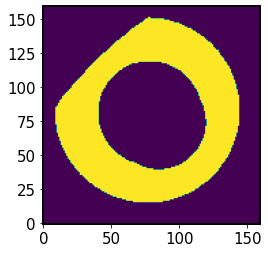

In [20]:
# Extract the region from the center of image and get the original one
show_lutxyp_extracted = extractArray(show_lutxyp_eroded, projSamples)
plt.imshow(show_lutxyp_extracted, origin='lower')

Now the re-centering step, to ensure that I1 and I2 after being shifted to the pupil plane are  aligned.

The `centerOnProjection` does the following :

In [21]:
img = I1.getImg()
template = show_lutxyp_extracted.astype(float)
window = 20 

# Calculate the cross-correlate
corr = correlate(img, template, mode="same")


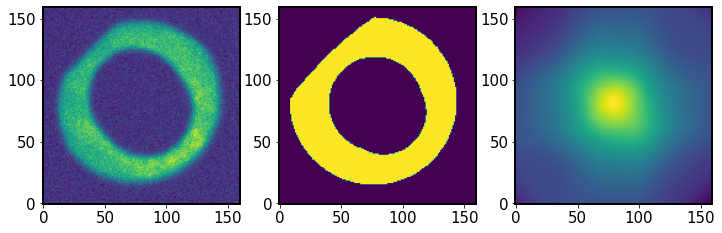

In [22]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(img, origin='lower')
ax[1].imshow(template,origin='lower')
ax[2].imshow(corr,origin='lower')

We only select the central region of the image convolution:

In [23]:

# Calculate the shifts of center

# Only consider the shifts in a certain window (range)
# Align the input image to the center of template
length = template.shape[0]
print(length)

160


In [24]:
center = length // 2
print(center)
r = window // 2
print(r)

80
10


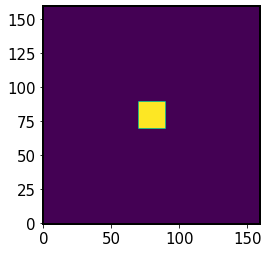

In [25]:
mask = np.zeros(corr.shape)
mask[center - r : center + r, center - r : center + r] = 1
plt.imshow(mask, origin='lower')

After convolving the template with the mask we select only the central region of the convolved image :

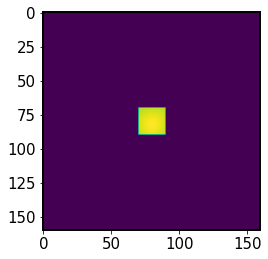

In [26]:
plt.imshow(corr*mask
          )

We find where is the peak of this window, and shift the image so that the peak is in the center: 

In [27]:
idx = np.argmax(corr * mask)
idx

13199

In [28]:
# The above 'idx' is an interger. Need to rematch it to the
# two-dimension position (x and y)
xmatch = idx % length
ymatch = idx // length
print(xmatch, ymatch)

79 82


In [29]:
dx = center - xmatch
dy = center - ymatch
print(dx,dy)

1 -2


show the effect of recentering on the image:

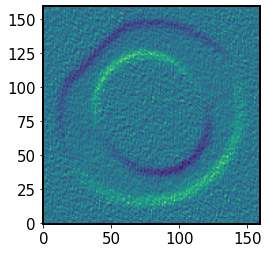

In [30]:
# Shift/ recenter the input image
imgRecenter = np.roll(np.roll(img, dx, axis=1), dy, axis=0)
plt.imshow(imgRecenter/img, origin='lower')

## Run entire algorithm with multiple iterations. Compare the amount of shift imparted by `coCenter` vs `reCenter` (aka `centerOnProjection`)

Store various elements of running the algorithm, but without plotting anything. Can always plot anything desired later (much better than plotting on-the-fly...). To do that I copy most of the code from `Algorithm` or `CompensableImage` , adding the ability to provide (and update) a `store` dictionary. 

Each function doesn't care how it's called. I can have one dictionary for each image, and one for the common things (eg. once two images are combined into eg `sum` and `difference` inside the Poisson algorithm... 


Each dictionary can be instead a key unto a higher-level dictionary, eg. 

    store_all[iteration_number]['intra'] = {}
    store_all[iteration_number]['extra'] = {}
    store_all[iteration_number]['common'] = {}

etc. 

First, define all the algorithm and compensable image modified functions that have a lot of added storage capabilities:

In [81]:
from scipy.ndimage import generate_binary_structure, iterate_structure
from scipy.ndimage import binary_dilation, binary_erosion
from scipy.interpolate import RectBivariateSpline
from scipy.signal import correlate

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularGrad,
    ZernikeAnnularJacobian,
)
from lsst.ts.wep.cwfs.Image import Image
from lsst.ts.wep.Utility import DefocalType, CentroidFindType
from galsim.utilities import horner2d

import yaml
import os
import numpy as np
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

from lsst.ts.wep.cwfs.Tool import (
    padArray,
    extractArray,
    ZernikeAnnularEval,
    ZernikeMaskedFit,
)

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'
        ] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

def imageCoCenter_store(I, inst, fov=3.5, debugLevel=0,
                       store=None):
    """Shift the weighting center of donut to the center of reference
    image with the correction of projection of fieldX and fieldY.
    Parameters
    ----------
    inst : Instrument
        Instrument to use.
    fov : float, optional
        Field of view (FOV) of telescope. (the default is 3.5.)
    debugLevel : int, optional
        Show the information under the running. If the value is higher, the
        information shows more. It can be 0, 1, 2, or 3. (the default is
        0.)
    """

    # Calculate the weighting center (x, y) and radius
    x1, y1 = I._image.getCenterAndR()[0:2]
    store['cocenter_centroid_x1'] = x1
    store['cocenter_centroid_y1'] = y1

    # Show the co-center information
    if debugLevel >= 3:
        print("imageCoCenter: (x, y) = (%8.2f,%8.2f)\n" % (x1, y1))

    # Calculate the center position on image
    # 0.5 is the half of 1 pixel
    dimOfDonut = inst.getDimOfDonutOnSensor()
    stampCenterx1 = dimOfDonut / 2 + 0.5
    stampCentery1 = dimOfDonut / 2 + 0.5
    store['cocenter_centerx1_original'] = stampCenterx1
    store['cocenter_centerx1_original'] = stampCentery1

    # Shift in the radial direction
    # The field of view (FOV) of LSST camera is 3.5 degree
    offset = inst.getDefocalDisOffset()
    pixelSize = inst.getCamPixelSize()
    radialShift = fov * (offset / 1e-3) * (10e-6 / pixelSize)
    store['cocenter_fov'] = fov
    store['cocenter_offset'] = offset
    store['cocenter_pixelSize'] = pixelSize

    # Calculate the projection of distance of donut to center
    fieldDist = I._getFieldDistFromOrigin()
    radialShift = radialShift * (fieldDist / (fov / 2))
    store['cocenter_fieldDist'] = fieldDist
    store['cocenter_radialShift'] = radialShift

    # Do not consider the condition out of FOV of lsst
    if fieldDist > (fov / 2):
        radialShift = 0

    # Calculate the cos(theta) for projection
    I1c = I.fieldX / fieldDist

    # Calculate the sin(theta) for projection
    I1s = I.fieldY / fieldDist
    store['cocenter_xShift'] = radialShift * I1c
    store['cocenter_yShift'] = radialShift * I1s

    # Get the projected x, y-coordinate        
    stampCenterx1 = stampCenterx1 + radialShift * I1c
    stampCentery1 = stampCentery1 + radialShift * I1s
    store['cocenter_centerx1_shifted'] = stampCenterx1
    store['cocenter_centery1_shifted'] = stampCentery1

    # Shift the image to the projected position
    I.updateImage(
        np.roll(I.getImg(), int(np.round(stampCentery1 - y1)), axis=0)
    )
    I.updateImage(
        np.roll(I.getImg(), int(np.round(stampCenterx1 - x1)), axis=1)
    )
    store['cocenter_x_shift_amount'] = int(np.round(stampCentery1 - y1))
    store['cocenter_y_shift_amount'] = int(np.round(stampCenterx1 - x1))
    return I, store

def centerOnProjection_store(img, template, window=20,
                            store=None):
    """Center the image to the template's center.
    Parameters
    ----------
    img : numpy.array
        Image to be centered with the template. The input image needs to
        be a n-by-n matrix.
    template : numpy.array
        Template image to have the same dimension as the input image
        ('img'). The center of template is the position of input image
        tries to align with.
    window : int, optional
        Size of window in pixel. Assume the difference of centers of input
        image and template is in this range (e.g. [-window/2, window/2] if
        1D). (the default is 20.)
    Returns
    -------
    numpy.array
        Recentered image.
    """

    # Calculate the cross-correlate
    corr = correlate(img, template, mode="same")

    # Calculate the shifts of center

    # Only consider the shifts in a certain window (range)
    # Align the input image to the center of template
    length = template.shape[0]
    center = length // 2

    r = window // 2

    mask = np.zeros(corr.shape)
    mask[center - r : center + r, center - r : center + r] = 1
    idx = np.argmax(corr * mask)

    # The above 'idx' is an interger. Need to rematch it to the
    # two-dimension position (x and y)
    xmatch = idx % length
    ymatch = idx // length

    dx = center - xmatch
    dy = center - ymatch
    store['recenter_x_shift'] = dx
    store['recenter_y_shift'] = dy
    
    # Shift/ recenter the input image
    return np.roll(np.roll(img, dx, axis=1), dy, axis=0), store



def compensate_store(I, inst, algo, zcCol, model, store):
    ''' Do the image compensation, but keep 
    calculated quantities in a dictionary for
    plotting later
    '''
    # initialize storage dictionary if needed
    if store is None:
        store = {}
    # else, assume storage is an already existing dictionary 
    store['imgBeforeCompensate'] = I.getImg()
    # Dimension of image
    sm, sn = I.getImg().shape

    # Dimension of projected image on focal plane
    projSamples = sm

    # Let us create a look-up table for x -> xp first.
    luty, lutx = np.mgrid[
        -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),
        -(projSamples / 2 - 0.5) : (projSamples / 2 + 0.5),

    ]

    sensorFactor = algo._inst.getSensorFactor()
    lutx = lutx / (projSamples / 2 / sensorFactor)
    luty = luty / (projSamples / 2 / sensorFactor)


    # Set up the mapping
    lutxp, lutyp, J = I._aperture2image(
    inst, algo, zcCol, lutx, luty, projSamples, model
    )

    show_lutxyp = I._showProjection(
                lutxp, lutyp, sensorFactor, projSamples, raytrace=False
            )
    store['show_lutxyp'] = show_lutxyp

    # Extend the dimension of image by 20 pixel in x and y direction
    show_lutxyp_padded = padArray(show_lutxyp, projSamples + 20)


    # Get the binary matrix of image on pupil plane if raytrace=False
    struct0 = generate_binary_structure(2, 1)

    struct1 = iterate_structure(struct0, 4)

    struct = binary_dilation(struct1, structure=struct0, iterations=2).astype(int)

    show_lutxyp_dilated = binary_dilation(show_lutxyp_padded, structure=struct)

    show_lutxyp_eroded = binary_erosion(show_lutxyp_dilated, structure=struct)

    # Extract the region from the center of image and get the original one
    show_lutxyp_extracted = extractArray(show_lutxyp_eroded, projSamples)
    store['show_lutxyp_extracted'] = show_lutxyp_extracted

    imgRecenter, store = centerOnProjection_store(
                I.getImg(), show_lutxyp.astype(float), window=20, store=store
                                                    ) 

    I.updateImage(imgRecenter)
    store['imgAfterRecenter'] = imgRecenter

    # Construct the interpolant to get the intensity on (x', p') plane
    # that corresponds to the grid points on (x,y)
    yp, xp = np.mgrid[
        -(sm / 2 - 0.5) : (sm / 2 + 0.5), -(sm / 2 - 0.5) : (sm / 2 + 0.5)
    ]

    xp = xp / (sm / 2 / sensorFactor)
    yp = yp / (sm / 2 / sensorFactor)

    # Put the NaN to be 0 for the interpolate to use
    lutxp[np.isnan(lutxp)] = 0
    lutyp[np.isnan(lutyp)] = 0

    # Construct the function for interpolation
    ip = RectBivariateSpline(yp[:, 0], xp[0, :], I.getImg(), kx=1, ky=1)

    # Construct the projected image by the interpolation
    lutIp = ip(lutyp, lutxp, grid=False)
    store['lutIp'] = lutIp
    store['Jacobian'] = J 

    # Calculate the image on focal plane with compensation based on flux
    # conservation
    # I(x, y)/I'(x', y') = J = (dx'/dx)*(dy'/dy) - (dx'/dy)*(dy'/dx)
    I.updateImage(lutIp * J)

    if I.defocalType == DefocalType.Extra:
        I.updateImage(np.rot90(I.getImg(), k=2))
        #print('Rotated the extra-focal image')

    # Put NaN to be 0
    imgCompensate = I.getImg()
    imgCompensate[np.isnan(imgCompensate)] = 0

    # Check the compensated image has the problem or not.
    # The negative value means the over-compensation from wavefront error
    if np.any(imgCompensate < 0) and np.all(I.image0 >= 0):
        print(
            "WARNING: negative scale parameter, image is within caustic, zcCol (in um)=\n"
        )
        I.caustic = True

    # Put the overcompensated part to be 0
    imgCompensate[imgCompensate < 0] = 0
    I.updateImage(imgCompensate)
    store['imgAfterCompensate'] = I.getImg()
    return I, store


def _solvePoissonEq_store(algo, I1, I2, iOutItr=0, store=None):
    """Solve the Poisson's equation by Fourier transform (differential) or
    serial expansion (integration).
    There is no convergence for fft actually. Need to add the difference
    comparison and X-alpha method. Need to discuss further for this.
    Parameters
    ----------
    I1 : CompensableImage
        Intra- or extra-focal image.
    I2 : CompensableImage
        Intra- or extra-focal image.
    iOutItr : int, optional
        ith number of outer loop iteration which is important in "fft"
        algorithm. (the default is 0.)
    Returns
    -------
    numpy.ndarray
        Coefficients of normal/ annular Zernike polynomials.
    numpy.ndarray
        Estimated wavefront.
    """

    # Calculate the aperture pixel size
    apertureDiameter = algo._inst.getApertureDiameter()
    sensorFactor = algo._inst.getSensorFactor()
    dimOfDonut = algo._inst.getDimOfDonutOnSensor()
    aperturePixelSize = apertureDiameter * sensorFactor / dimOfDonut

    # Calculate the differential Omega
    dOmega = aperturePixelSize**2

    # Solve the Poisson's equation based on the type of algorithm
    numTerms = algo.getNumOfZernikes()
    zobsR = algo.getObsOfZernikes()
    PoissonSolver = algo.getPoissonSolverName()
    if PoissonSolver == "fft":

        # Use the differential method by fft to solve the Poisson's
        # equation

        # Parameter to determine the threshold of calculating I0.
        sumclipSequence = algo.getSignalClipSequence()
        cliplevel = sumclipSequence[iOutItr]

        # Generate the v, u-coordinates on pupil plane
        padDim = algo.getFftDimension()
        v, u = np.mgrid[
            -0.5
            / aperturePixelSize : 0.5
            / aperturePixelSize : 1.0
            / padDim
            / aperturePixelSize,
            -0.5
            / aperturePixelSize : 0.5
            / aperturePixelSize : 1.0
            / padDim
            / aperturePixelSize,
        ]

        # Show the threshold and pupil coordinate information
        if algo.debugLevel >= 3:
            print("iOuter=%d, cliplevel=%4.2f" % (iOutItr, cliplevel))
            print(v.shape)

        # Calculate the const of fft:
        # FT{Delta W} = -4*pi^2*(u^2+v^2) * FT{W}
        u2v2 = -4 * (np.pi**2) * (u * u + v * v)

        # Set origin to Inf to result in 0 at origin after filtering
        ctrIdx = int(np.floor(padDim / 2.0))
        u2v2[ctrIdx, ctrIdx] = np.inf

        # Calculate the wavefront signal
        Sini = algo._createSignal(I1, I2, cliplevel)

        # Find the just-outside and just-inside indices of a ring in pixels
        # This is for the use in setting dWdn = 0
        boundaryT = algo.getBoundaryThickness()

        struct = generate_binary_structure(2, 1)
        struct = iterate_structure(struct, boundaryT)

        ApringOut = np.logical_xor(
            binary_dilation(algo.mask_pupil, structure=struct), algo.mask_pupil
        ).astype(int)
        ApringIn = np.logical_xor(
            binary_erosion(algo.mask_pupil, structure=struct), algo.mask_pupil
        ).astype(int)

        bordery, borderx = np.nonzero(ApringOut)

        # Put the signal in boundary (since there's no existing Sestimate,
        # S just equals self.S as the initial condition of SCF
        S = Sini.copy()
        for jj in range(algo.getNumOfInnerItr()):

            # Calculate FT{S}
            SFFT = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(S)))

            # Calculate W by W=IFT{ FT{S}/(-4*pi^2*(u^2+v^2)) }
            W = np.fft.fftshift(
                np.fft.irfft2(np.fft.fftshift(SFFT / u2v2), s=S.shape)
            )

            # Estimate the wavefront (includes zeroing offset & masking to
            # the aperture size)

            # Take the estimated wavefront
            West = extractArray(W, dimOfDonut)

            # Calculate the offset
            offset = West[self.mask_pupil == 1].mean()
            West = West - offset
            West[self.mask_pupil == 0] = 0

            # Set dWestimate/dn = 0 around boundary
            WestdWdn0 = West.copy()

            # Do a 3x3 average around each border pixel, including only
            # those pixels inside the aperture. This averaging can be
            # efficiently computed using 1 numpy/scipy vectorized
            # convolve2d instruction to first sum the values in the 3x3
            # region, and dividing by a second convolve2d which counts
            # the non-zero pixels in each 3x3 region.

            kernel = np.ones((1 + 2 * boundaryT, 1 + 2 * boundaryT))
            tmp = convolve2d(West * ApringIn, kernel, mode="same")
            tmp /= convolve2d(ApringIn, kernel, mode="same")
            WestdWdn0[borderx, bordery] = tmp[borderx, bordery]

            # Take Laplacian to find sensor signal estimate (Delta W = S)
            del2W = laplace(WestdWdn0) / dOmega

            # Extend the dimension of signal to the order of 2 for "fft" to
            # use
            Sest = padArray(del2W, padDim)

            # Put signal back inside boundary, leaving the rest of
            # Sestimate
            Sest[algo.mask_pupil_pad == 1] = Sini[algo.mask_pupil_pad == 1]

            # Need to recheck this condition
            S = Sest

        # Calculate the coefficient of normal/ annular Zernike polynomials
        if algo.getCompensatorMode() == "zer":
            xSensor, ySensor = algo._inst.getSensorCoor()
            zc = ZernikeMaskedFit(
                West, xSensor, ySensor, numTerms, algo.mask_pupil, zobsR
            )
        else:
            zc = np.zeros(numTerms)

    elif PoissonSolver == "exp":

        # Use the integration method by serial expansion to solve the
        # Poisson's equation

        # Calculate I0 and dI
        I0, dI = algo._getdIandI(I1, I2)
        store['I0'] = I0
        store['dI'] = dI

        # Get the x, y coordinate in mask. The element outside mask is 0.
        xSensor, ySensor = algo._inst.getSensorCoor()
        xSensor = xSensor * algo.mask_comp
        ySensor = ySensor * algo.mask_comp

        # Create the F matrix and Zernike-related matrixes

        # Get Zernike and gradient bases from cache.  These are each
        # (nzk, npix, npix) arrays, with the first dimension indicating
        # the Noll index.
        zk, dzkdx, dzkdy = algo._zernikeBasisCache()

        # Eqn. (19) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
        # F_j = \int (d_z I) Z_j d_Omega
        F = np.tensordot(dI, zk, axes=((0, 1), (1, 2))) * dOmega
        # Eqn. (20) from Xin et al., Appl. Opt. 54, 9045-9054 (2015).
        # M_ij = \int I (grad Z_j) . (grad Z_i) d_Omega
        #      =   \int I (dZ_i/dx) (dZ_j/dx) d_Omega
        #        + \int I (dZ_i/dy) (dZ_j/dy) d_Omega
        Mij = np.einsum("ab,iab,jab->ij", I0, dzkdx, dzkdx)
        Mij += np.einsum("ab,iab,jab->ij", I0, dzkdy, dzkdy)
        Mij *= dOmega / (apertureDiameter / 2.0) ** 2

        # Calculate dz
        focalLength = algo._inst.getFocalLength()
        offset = algo._inst.getDefocalDisOffset()
        dz = 2 * focalLength * (focalLength - offset) / offset

        # Define zc
        zc = np.zeros(numTerms)

        # Consider specific Zk terms only
        idx = algo.getZernikeTerms()

        # Solve the equation: M*W = F => W = M^(-1)*F
        zc_tmp = np.linalg.lstsq(Mij[:, idx][idx], F[idx], rcond=None)[0] / dz
        zc[idx] = zc_tmp

        # Estimate the wavefront surface based on z4 - z22
        # z0 - z3 are set to be 0 instead
        West = ZernikeAnnularEval(
            np.concatenate(([0, 0, 0], zc[3:])), xSensor, ySensor, zobsR
        )

    return zc, West, store



def get_butler_stamps(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     dataset_type = 'donutStampsExtra', collection=''):
    #repoDir = '/project/scichris/aos/rotation_DM-31532/Ns_rotCam_0_c/phosimData/' 

    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0, 
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit 
    
    dataId = {'detector':detector, 'instrument':instrument,
              'visit':expN}

    donutStamps = butler.get(dataset_type, 
                              dataId=dataId, 
                              collections=[collection])  
    
    donutCatalog = butler.get('donutCatalog', 
                              dataId=dataId, 
                              collections=[collection]) 
    return donutStamps, donutCatalog

def get_butler_image(repoDir,instrument='LSSTComCam', iterN=0, detector="R22_S01",
                     collection=''):
    butler = dafButler.Butler(repoDir)
    registry = butler.registry
    if collection == '':
        collection=f'ts_phosim_90060{iterN}1'
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(butler.registry.queryDatasets(
                            datasetType='postISRCCD',
                            dataId=dataId0,
                            collections=[collection]  )
                       ))
    expN = dataset.dataId["exposure"]
    dataId = {'detector':detector, 'instrument':instrument,
          'exposure':expN}
    postIsr = butler.get('postISRCCD',dataId=dataId,
                          collections=[collection])
    return postIsr


def runIt_store(algo, I1, I2, model, tol=1e-3, store=None,
               doCoCenter=True):

    # To have the iteration time initiated from global variable is to
    # distinguish the manually and automatically iteration processes.
    itr = algo.currentItr
    if store is None:
        store = {}
    while itr <= algo.getNumOfOuterItr():

        stopItr, store = _singleItr_store(algo, I1, I2, model, tol, store,
                                         doCoCenter)

        # Stop the iteration of outer loop if converged
        if stopItr:
            break

        itr += 1
    
    return algo, store



def _singleItr_store(algo, I1, I2, model, tol=1e-3, store=None,
                    doCoCenter = True):
   
    #algo.debugLevel = 3 
    
    # Use the zonal mode ("zer")
    compMode = algo.getCompensatorMode()

    # Define the gain of feedbackGain
    feedbackGain = algo.getFeedbackGain()

    # Set the pre-condition
    # ... only zeroth iteration ... 
    # Rename this index (currentItr) for the simplification
    jj = algo.currentItr
    print('iteration ', jj)
    store[jj] = {'intra':{}, 'extra':{}, 'both':{}}
    if jj == 0:

        # Check this is the first time of running iteration or not
        if I1.getImgInit() is None or I2.getImgInit() is None:

            # Check the image dimension
            if I1.getImg().shape != I2.getImg().shape:
                print(
                    "Error: The intra and extra image stamps need to be of same size."
                )


            # Calculate the pupil mask (binary matrix) and related
            # parameters
            boundaryT = algo.getBoundaryThickness()
            I1.makeMask(algo._inst, model, boundaryT, 1)
            I2.makeMask(algo._inst, model, boundaryT, 1)
            
            algo._makeMasterMask(I1, I2, algo.getPoissonSolverName())
            store[jj]['both']['mask_pupil'] = algo.mask_pupil
            store[jj]['both']['mask_comp'] = algo.mask_comp
            
        # Load the offAxis correction coefficients
        if model == "offAxis":
            offAxisPolyOrder = algo.getOffAxisPolyOrder()
            I1.setOffAxisCorr(algo._inst, offAxisPolyOrder)
            I2.setOffAxisCorr(algo._inst, offAxisPolyOrder)

        # store images before co-centering
        store[jj]['intra']['imgBeforeCocenter'] = I1.getImg()
        store[jj]['extra']['imgBeforeCocenter'] = I2.getImg()
        
        # default value 
        store[jj]['doCoCenter'] = False
        if doCoCenter : 
            
            I1, store[jj]['intra'] = imageCoCenter_store(I1, algo._inst, 
                                                     store=store[jj]['intra'])
            I2, store[jj]['extra'] = imageCoCenter_store(I2, algo._inst, 
                                                     store=store[jj]['extra'])
            # override default if actually done that 
            store[jj]['doCoCenter'] = True 
        
        # store images after that step whether it 
        # has been done or not... 
        store[jj]['intra']['imgAfterCocenter'] = I1.getImg()
        store[jj]['extra']['imgAfterCocenter'] = I2.getImg()

        # Update the self-initial image
        I1.updateImgInit()
        I2.updateImgInit()
    
        # Initialize the variables used in the iteration.
        algo.zcomp = np.zeros(algo.getNumOfZernikes())
        algo.zc = algo.zcomp.copy()
        store[jj]['both']['zcomp'] = algo.zcomp
        store[jj]['both']['zc'] = algo.zc

        dimOfDonut = algo._inst.getDimOfDonutOnSensor()
        algo.wcomp = np.zeros((dimOfDonut, dimOfDonut))
        algo.West = algo.wcomp.copy()
        store[jj]['both']['wcomp'] = algo.wcomp
        store[jj]['both']['West'] = algo.West
        algo.caustic = False

        # ... only zeroth iteration ... 
            
            
    # Solve the transport of intensity equation (TIE)
    if not algo.caustic:

        # Reset the images before the compensation
        I1.updateImage(I1.getImgInit().copy())
        I2.updateImage(I2.getImgInit().copy())

        if compMode == "zer":

            # Zk coefficient from the previous iteration
            ztmp = algo.zc.copy()

            # Do the feedback of Zk from the lower terms first based on the
            # sequence defined in compSequence
            if jj != 0:
                compSequence = algo.getCompSequence()
                #print(compSequence)
                ztmp[int(compSequence[jj - 1]) :] = 0

            # Add partial feedback of residual estimated wavefront in Zk
            algo.zcomp = algo.zcomp + ztmp * feedbackGain

            # store the image so that nothing in the below will affect it 
            intraBeforeCompensate = I1.getImg()

            I1,  store[jj]['intra'] = compensate_store(I1, algo._inst, 
                                                       algo, algo.zcomp, 
                                                       model, store=store[jj]['intra'])
            I2,  store[jj]['extra'] = compensate_store(I2, algo._inst, 
                                                       algo, algo.zcomp, 
                                                       model, store=store[jj]['extra'])

        # Correct the defocal images if I1 and I2 are belong to different
        # sources, which is determined by the (fieldX, field Y)
        I1, I2 = algo._applyI1I2mask_pupil(I1, I2)
        store[jj]['intra']['applyI1I2mask_pupil'] = I1.getImg()
        store[jj]['extra']['applyI1I2mask_pupil'] = I2.getImg()

        #  self.zc, self.West = self._solvePoissonEq(I1, I2, jj) 
        algo.zc, algo.West, store[jj]['both'] = _solvePoissonEq_store(algo, 
                                                    I1, I2, jj, 
                                                    store[jj]['both'])


        # Record/ calculate the Zk coefficient and wavefront
        if compMode == "zer":
            algo.converge[:, jj] = algo.zcomp + algo.zc

            xoSensor, yoSensor = algo._inst.getSensorCoorAnnular()
            algo.wcomp = algo.West + ZernikeAnnularEval(
                np.concatenate(([0, 0, 0], algo.zcomp[3:])),
                xoSensor,
                yoSensor,
                algo.getObsOfZernikes(),
            )

    else:
        # Once we run into caustic, stop here, results may be close to real
        # aberration.
        # Continuation may lead to disastrous results.
        algo.converge[:, jj] = algo.converge[:, jj - 1]

    # Record the coefficients of normal/ annular Zernike polynomials after
    # z4 in unit of nm
    algo.zer4UpNm = algo.converge[3:, jj] * 1e9

    store[jj]['zer4UpNm'] = algo.zer4UpNm
    
    # Status of iteration
    stopItr = False

    # Calculate the difference
    if jj > 0:
        diffZk = (
            np.sum(np.abs(algo.converge[:, jj] - algo.converge[:, jj - 1])) * 1e9
        )

        # Check the Status of iteration
        if diffZk < tol:
            stopItr = True

    # Update the current iteration time
    algo.currentItr += 1

    # Show the Zk coefficients in interger in each iteration
    if algo.debugLevel >= 2:
        print("itr = %d, z4-z%d" % (jj, algo.getNumOfZernikes()))
        print(np.rint(algo.zer4UpNm))

    return stopItr, store
        

## Initialize where the data come from and the algorithm setup: 

In [82]:
#repo_dir  = 'DM-35919_phosim_example/example_wfs/phosimData'
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name) 
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
donutStampsExtra, extraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector="R04_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)
sensor='R04'
extraImage = get_butler_image(repo_dir,instrument=instrument,
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

# get the pixel scale from exposure to convert from pixels to arcsec to degrees
pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")


## Turn `coCenter` on and off, run the actual wavefront estimation (14 outer loops) for all donut pairs

In [83]:
i=1 # only one extra-focal donut 
#j=0 
for doCoCenter in [True,False]:
    for j in range(1):#len(donutStampsIntra)): # only one intra-focal donut 

        # this is part of the init
        inst = Instrument(instDir)
        algo = Algorithm(algoDir)

        # inside estimateZernikes()
        instName='lsst'
        camType = getCamType(instName)
        defocalDisInMm = getDefocalDisInMm(instName)

        # inside wfEsti.config
        opticalModel = 'offAxis'
        sizeInPix = 160  # aka donutStamps
        inst.config(camType,sizeInPix, announcedDefocalDisInMm=defocalDisInMm)

        # choose the solver for the algorithm
        solver = 'exp' # by default
        debugLevel = 1 # 1 to 3
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        # select the only donut pair in that corner
        donutExtra = donutStampsExtra[i]
        donutIntra = donutStampsIntra[j]

        # Inside EstimateZernikesBase
        # Transpose field XY because CompensableImages below are transposed
        # so this gets the correct mask orientation in Algorithm.py
        fieldXYExtra = donutExtra.calcFieldXY()[::-1]
        fieldXYIntra = donutIntra.calcFieldXY()[::-1]

        camera = donutExtra.getCamera() # same camera for both donuts
        detectorExtra = camera.get(donutExtra.detector_name)
        detectorIntra = camera.get(donutIntra.detector_name)


        # Rotate any sensors that are not lined up with the focal plane.
        # Mostly just for the corner wavefront sensors. The negative sign
        # creates the correct rotation based upon closed loop tests
        # with R04 and R40 corner sensors.
        eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
        eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

        # now inside  `wfEsti.setImg` method,
        # which inherits from `CompensableImage`
        imgExtra.setImg(fieldXYExtra,
                        DefocalType.Extra,
                        image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

        imgIntra.setImg(fieldXYIntra,
                        DefocalType.Intra,
                        image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

        boundaryT = algo.getBoundaryThickness()

        # right after we set the image, the compensable image mask is empty -
        # it is only calculated later in Algorithm
        maskScalingFactorLocal = 1


        # rename to just like it is in Algorithm.py
        algo, store = runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                  tol=1e-3,doCoCenter=doCoCenter)

        # save the values for that donut pair and cocenter
        coCenterText = 'noCocenter'
        if doCoCenter:
            coCenterText = 'doCocenter'

        fname = f'DM-35922_store_extra-{i}_intra-{j}_{coCenterText}N.npy'
        print(fname)
        np.save(fname, store, )

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
DM-35922_store_extra-1_intra-0_doCocenterN.npy
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
DM-35922_store_extra-1_intra-0_noCocenterN.npy


Compare retrieved zernikes for these 10 donut pairs with different amounts of vignetting - does `coCenter` make a noticeable difference?

In [84]:
store = np.load(fname, allow_pickle=True).item()

plot all 14 outer loops to find out what's the progression as zk's are fit:

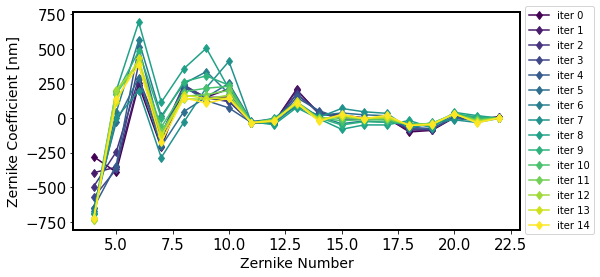

In [59]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

nlines = len(store.keys())
color_idx = np.linspace(0, 1, nlines)
ax_legend_handles = []
cmap = plt.cm.viridis

for jj in store.keys():
    color = cmap(color_idx[jj])
    plt.plot(np.arange(4, 23),store[jj]['zer4UpNm'], '-d', label=f'iter {jj}',
            color=color)
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 )
    ax_legend_handles.append(f'iter {jj} ')
    
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend( bbox_to_anchor=[1, 1.05])

Compare the final zk for each donut pair (with and without co-centering)...

Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0
Diff sum: 0.0


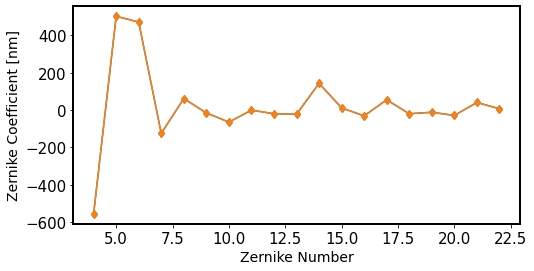

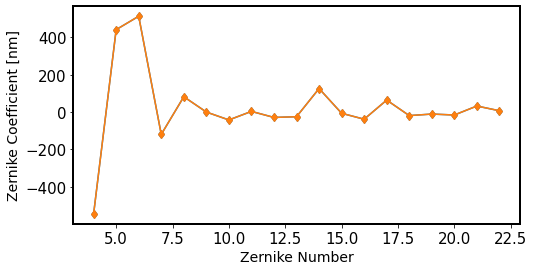

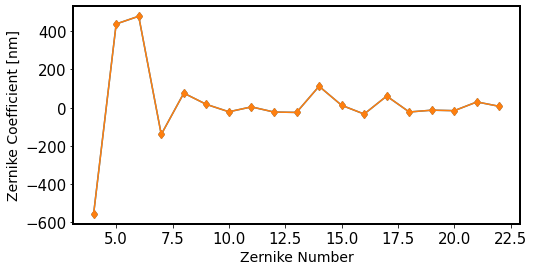

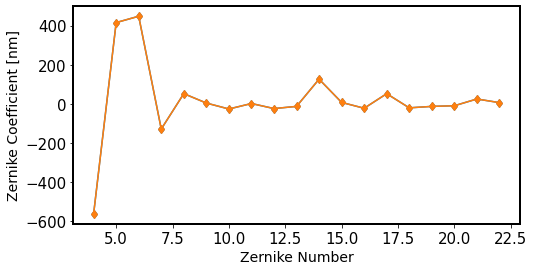

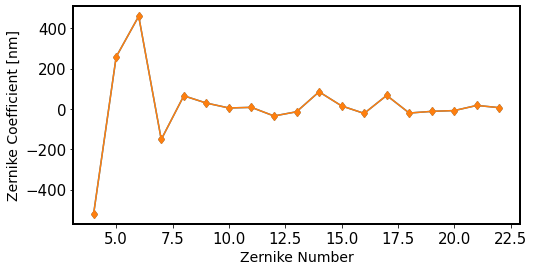

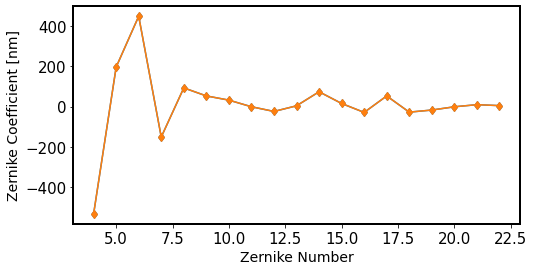

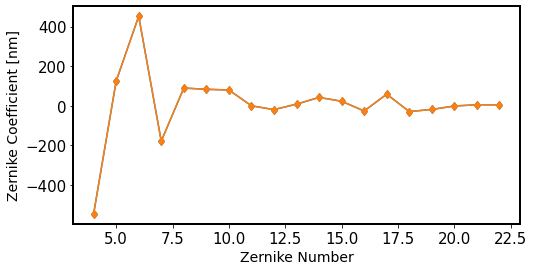

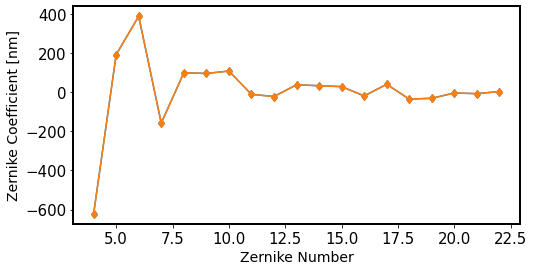

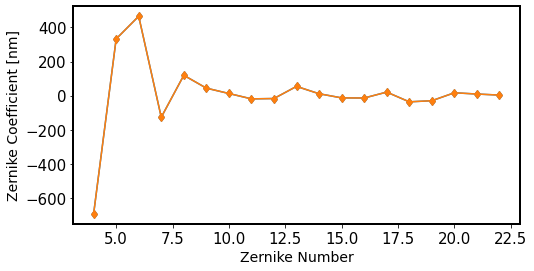

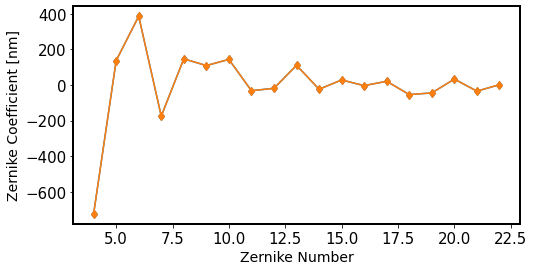

In [71]:
i=1
for j in range(10):

    fname = f'DM-35922_store_extra-{i}_intra-{j}_doCocenter.npy'
    store0 = np.load(fname, allow_pickle=True).item()

    fname = f'DM-35922_store_extra-{i}_intra-{j}_noCocenter.npy'
    store1 = np.load(fname, allow_pickle=True).item()

    fig,ax = plt.subplots(1,1,figsize=(8,4))
    zk0 = store0[14]['zer4UpNm']
    zk1 = store1[14]['zer4UpNm']
    
    plt.plot(np.arange(4, 23),zk0, '-d', label=f'{co}Center',
                )

    plt.plot(np.arange(4, 23),zk1, '-d', label=f'{co}Center',
                )

    plt.xlabel('Zernike Number', size=14)
    plt.ylabel('Zernike Coefficient [nm]', size=14)
    print('Diff sum:', np.sum(zk0-zk1))

I find that there is absolutely no difference whether we do the coCenter step or not! 

Even though slightly different values are arrived at with each donut pair, i.e. the fitting does work:

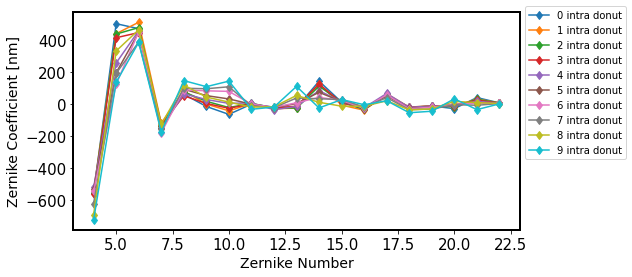

In [74]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

for j in range(10):

    fname = f'DM-35922_store_extra-{i}_intra-{j}_doCocenter.npy'
    store0 = np.load(fname, allow_pickle=True).item()

#  fname = f'DM-35922_store_extra-{i}_intra-{j}_noCocenter.npy'
#     store1 = np.load(fname, allow_pickle=True).item()
    zk0 = store0[14]['zer4UpNm']
    plt.plot(np.arange(4, 23),zk0, '-d', label=f'{j} intra donut',
                )

plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', size=14)
plt.legend(bbox_to_anchor=[1, 1.05])

## Look at one of these in detail. Find the amount of shift applied with coCenter vs reCenter 

In [85]:
i=1
j=0
fname = f'DM-35922_store_extra-{i}_intra-{j}_doCocenterN.npy'
store = np.load(fname, allow_pickle=True).item()

In [86]:
store[0]['intra']

{'imgBeforeCocenter': array([[309.09033, 293.84268, 278.59503, ..., 308.07382, 306.0408 ,
         312.13986],
        [310.10684, 314.17288, 313.15637, ..., 314.17288, 356.8663 ,
         323.32147],
        [305.0243 , 310.10684, 312.13986, ..., 292.82617, 298.92523,
         322.30496],
        ...,
        [266.3969 , 310.10684, 283.67758, ..., 299.94174, 308.07382,
         288.76013],
        [321.28845, 297.90872, 324.33798, ..., 319.25543, 315.1894 ,
         321.28845],
        [309.09033, 338.56912, 307.0573 , ..., 315.1894 , 277.57852,
         318.23892]], dtype=float32),
 'cocenter_centroid_x1': 77.92284866468843,
 'cocenter_centroid_y1': 78.06703533854869,
 'cocenter_centerx1_original': 80.5,
 'cocenter_fov': 3.5,
 'cocenter_offset': 0.0015,
 'cocenter_pixelSize': 1e-05,
 'cocenter_fieldDist': 1.7405977636564052,
 'cocenter_radialShift': 5.221793290969215,
 'cocenter_xShift': -3.6022499999999993,
 'cocenter_yShift': 3.7803333333333327,
 'cocenter_centerx1_shifted': 76.897

In [87]:
for itr in store.keys():
    print('\nitr=',itr)
    if itr == 0:
        dx_cocenter = store[itr]['intra']['cocenter_x_shift_amount']
        dy_cocenter = store[itr]['intra']['cocenter_y_shift_amount']
        print('cocenter', dx_cocenter, dy_cocenter)
    
    dx_recenter = store[itr]['intra']['recenter_x_shift']
    dy_recenter = store[itr]['intra']['recenter_y_shift']
    print('recenter', dx_recenter, dy_recenter)



itr= 0
cocenter 6 -1
recenter 1 -3

itr= 1
recenter 0 -3

itr= 2
recenter 1 -3

itr= 3
recenter 1 -3

itr= 4
recenter 1 -2

itr= 5
recenter 1 -2

itr= 6
recenter 1 -2

itr= 7
recenter 1 -2

itr= 8
recenter 1 -3

itr= 9
recenter 1 -3

itr= 10
recenter 1 -2

itr= 11
recenter 1 -2

itr= 12
recenter 1 -3

itr= 13
recenter 1 -3

itr= 14
recenter 1 -3


Plot the stored images 

In [88]:
def plot_algo_steps(store,iterNum=0):

    # read in the file
    
    #fname = f'DM-35922_store_extra-{extraCounter}_intra-{intraCounter}_doCocenter.npy'
    #store = np.load(fname, allow_pickle=True).item()
    titles = {}
    if iterNum == 0 : 
        titles['imgBeforeCocenter']='before coCenter'
        titles['imgAfterCocenter']='after coCenter'
        
    # for all other iterations including zeroth one 
    titles['imgBeforeCompensate']='before compensation'
    titles['show_lutxyp']='projection of image \ncoordinates onto pupil \n(show_lutxyp)'
    titles['show_lutxyp_extracted']='cleaned-up projection'
    titles['imgAfterRecenter']='recentered image'
    titles['lutIp']='interpolated image \n(lutIp)'
    titles['Jacobian']='Jacobian'
    titles['imgAfterCompensate']='after compensation'
    titles['applyI1I2mask_pupil']='apply common pupil mask'


    rows=len(titles.keys())
    fig,ax = plt.subplots(rows,2, figsize=(6,3*rows))
    ax[0,0].text(0.8,1.2,f'iteration {iterNum}',
                transform=ax[0,0].transAxes,
                fontsize=19)
    for defocal,col in zip(['intra', 'extra'],
                           [0,1]):
        print(defocal,col)
        row=0
        for key in titles.keys():
            ax[row,col].imshow(store[iterNum][defocal][key], origin='lower')
            row+=1 
    row=0
    for key in titles.keys():
        ax[row,1].text(1.05,0.5, titles[key], fontsize=19,transform=ax[row,1].transAxes)
        row += 1 
    ax[0,0].set_title('intra (I1)')
    ax[0,1].set_title('extra (I2)')

    #    imgInit  : before coCenter
    #None --> imgAfterCocenter : after coCenter (if done )   
    # img --> imgBeforeCompensate   "before compensation"
    # show_lutxyp (projection) "projection of image \ncoordinates onto pupil \n(show_lutxyp)"
    # show_lutxyp_extracted "cleaned-up projection"
    # imgRecenter --> imgAfterRecenter  "recentered image"
    # lutIp    "interpolated image \n(lutIp)"
    # Jacobian 
    # imgFinal --> imgAfterCompensate  "after compensation"
    # applyI1I2mask_pupil  "apply common pupil mask"
    #  

intra 0
extra 1


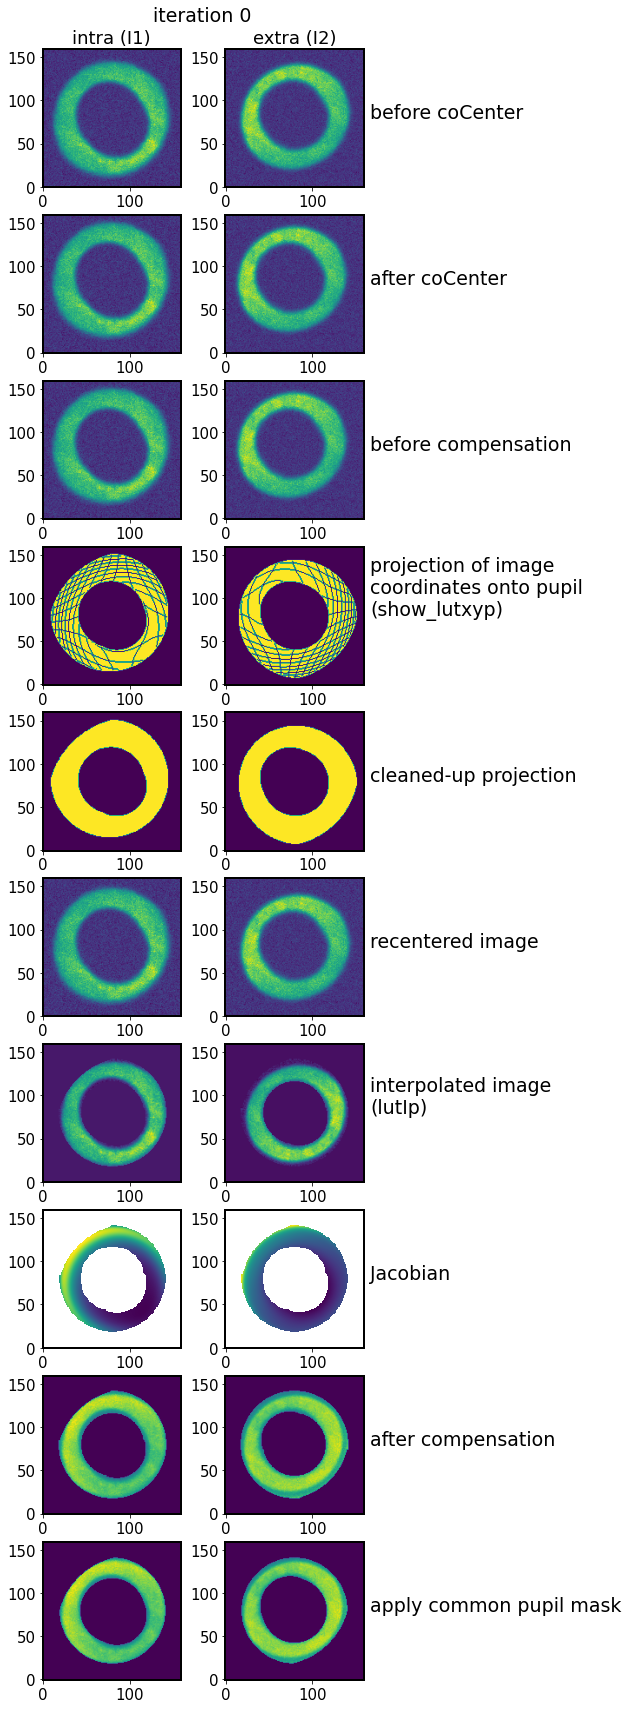

In [91]:
plot_algo_steps(store,iterNum=0)

intra 0
extra 1


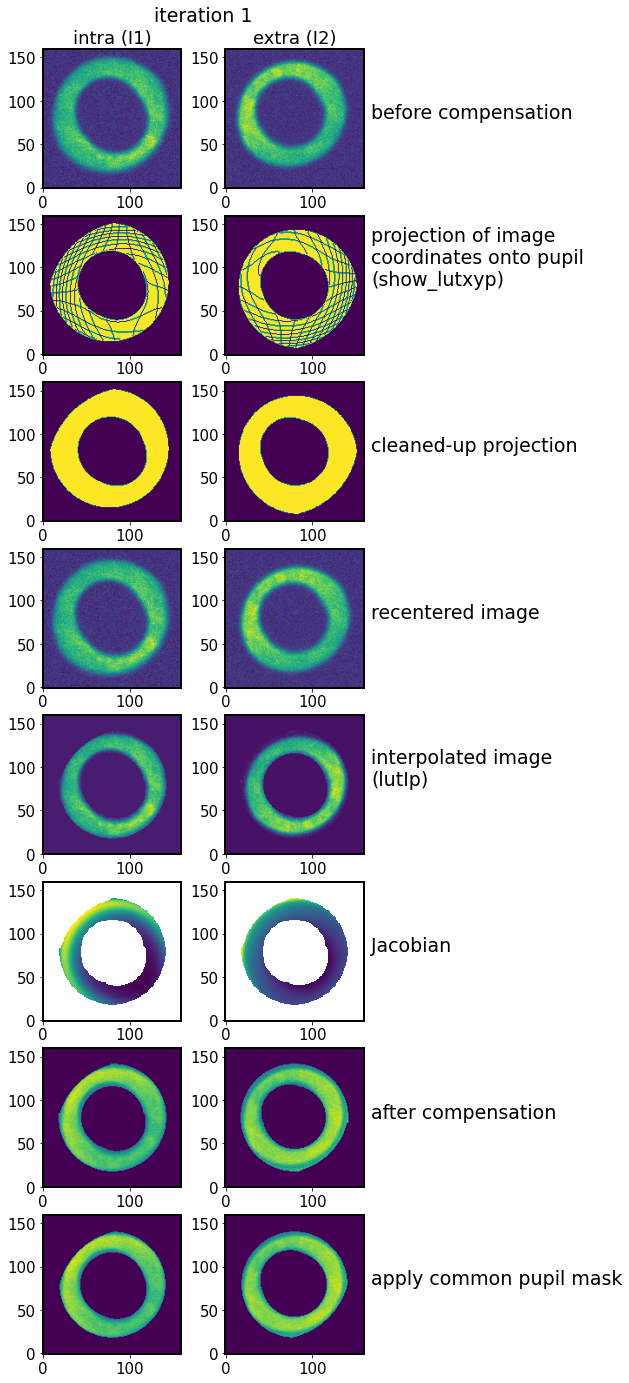

In [92]:
plot_algo_steps(store, iterNum=1)

intra 0
extra 1


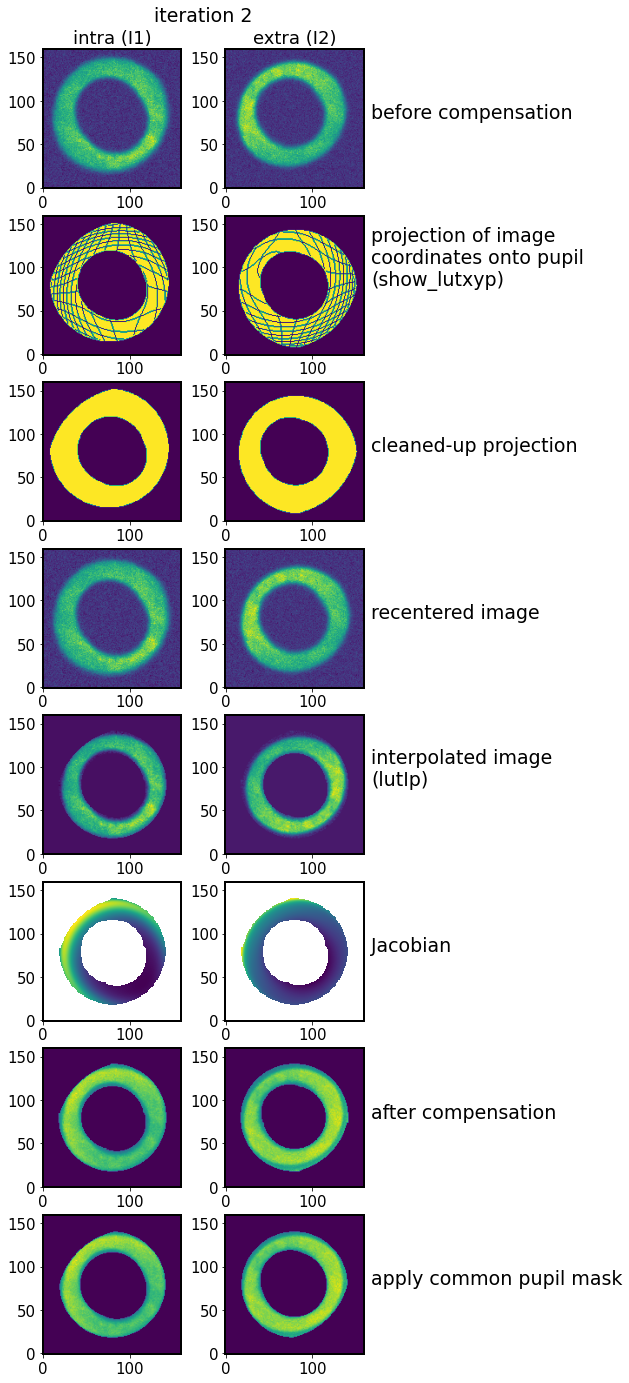

In [93]:
plot_algo_steps(store,iterNum=2)

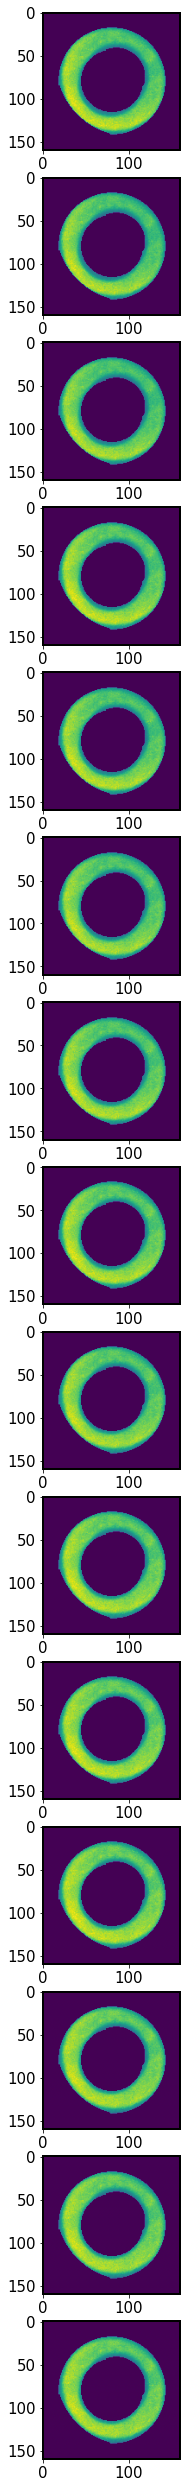

In [95]:
rows = len(store.keys())
fig,ax = plt.subplots(rows,1,figsize=(6,3*rows))
for row in range(rows):
    ax[row].imshow(store[row]['intra']['imgAfterCompensate'])

Also, what do we shift from ...


cocenter  : 
    
    shift the original image by the difference between geometric center (x,y) and the amount indicated by the radial shift. This is the imgInit , that is used at each iteration 

recenter : 
    
    shift the imgInit by the difference between geometric center (x,y) and the peak of the correlation between the image and the projection template . The projection template may be dfifferent in each of hte outer iterations (but why would it be?  
    
    
Quick questions:
    - why in iter0  intra  template is rotated wrt iter1 ? (in all subsequent iterations they retain the rotated orientation)
    - why this doesn't happen for the extra template? (it has the same orientation throughout...) 

Bitwise identical! Need to run more tests, but in that single Zk estimation I find absolutely no difference in whether I iuse co-centering or not ... 

It is in the `_solvePoissonEq` that we call `_checkImageDim`  via `_getdIandI` if  using `exp` solver, and via `_createSignal`  if using `fft` solver. But either way,  it is at the Poisson solver stage that the images are finally rotated to the same orientation: 

Text(0.5, 1.0, 'dI = I2-I1')

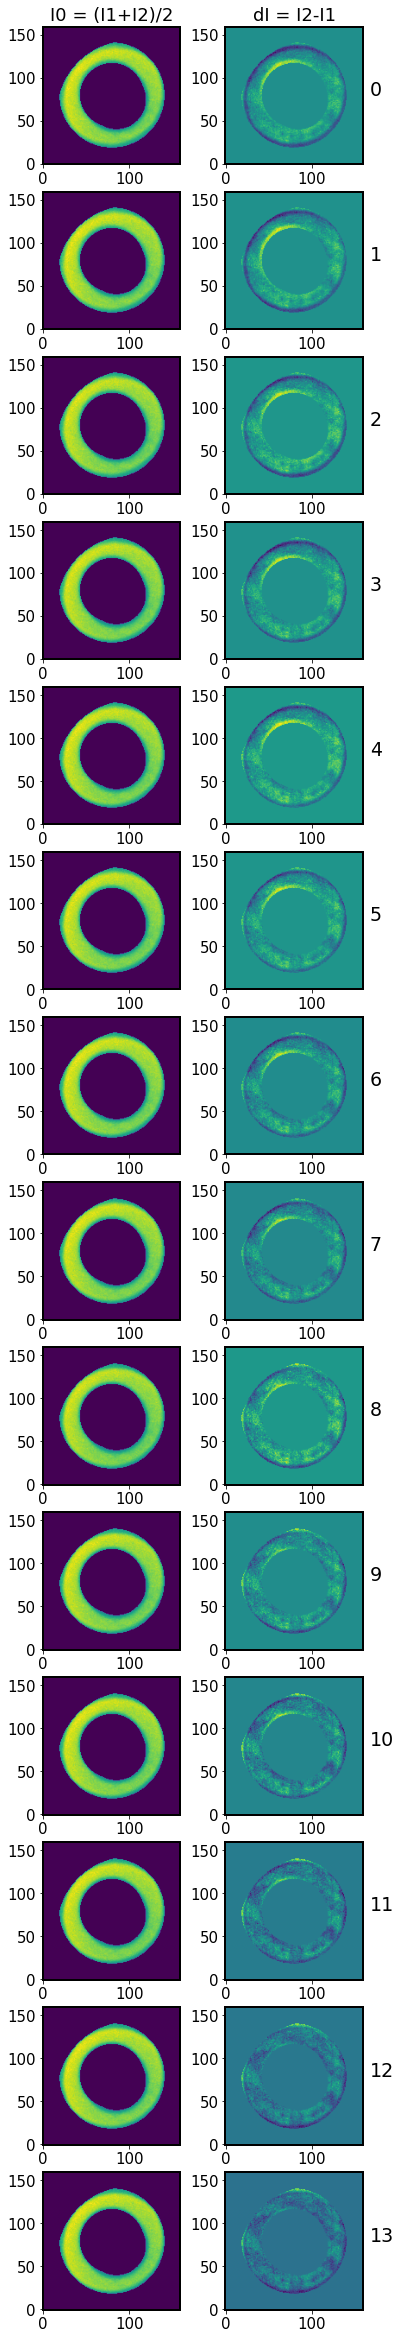

In [102]:
rows = 14
fig,ax = plt.subplots(rows,2,figsize=(6,3*rows))

for iterNum in range(rows):
    row=iterNum
    ax[row,0].imshow(store[iterNum]['both']['I0'], origin='lower')
    ax[row,1].imshow(store[iterNum]['both']['dI'], origin='lower')
    ax[row,1].text(1.05,0.5, iterNum, fontsize=19,transform=ax[row,1].transAxes)

row=0
ax[row,0].set_title('I0 = (I1+I2)/2')
ax[row,1].set_title('dI = I2-I1')

We see especially in the difference image that the brightness effects on the edge get mitigated with increasing iteration number...